In [ ]:
# This python script uses sympy functions to reproduce the calculations performed by OpenFAST Elastodyn module
# The aim of this script is to provide a cmprehensible multibody formulation of wind turbines
# for structural dynamic simulations. The multibody formulation is based on the Kane's method.

# OpenFAST is maintained and developed by researchers and software engineers at NREL,
# with support from the US Department of Energy's Wind Energy Technology Office.
# OpenFAST is an open source software licensed under the Apache License 2.0.

# SymPy is a Python library for symbolic mathematics.
# It aims to become a full-featured computer algebra system (CAS) while keeping the code as simple as possible
# in order to be comprehensible and easily extensible. SymPy is written entirely in Python.
# Copyright © 2023 SymPy Development Team.

# Author: Dr.Ing. Feng Guo (郭峰) 
# Contacts: fengguokm@sjtu.edu.cn
# licensed under the Apache License 2.0.

# This code is published as the attachment of this publication:
# TorqTwin—An open-source reference multibody modeling framework for wind turbine structural dynamics
# Feng Guo^a,Zhen Gao^a, David Schlipf^b,c
# State Key Laboratory of Ocean Engineering, Shanghai Jiao Tong University, 800 Dongchuan Road, Shanghai, China
# Wind Energy Technology Institute, Flensburg University of Applied Sciences, Kanzleistraße 91-93, 24943 Flensburg, Germany
# sowento GmbH, Hessenlauweg 14, 70569 Stuttgart, Germany
# https://doi.org/10.1016/j.renene.2024.121268

#This code is mainly for educational purposes. Executing the code can be time-consuming. Please be patient or reduce the degree of freedoms!!! 

In [ ]:
from ReadInputs_Elastodyn import ReadInputs_Elastodyn, ReadInputs_Blade, ReadInputs_Tower
from SetParameters import SetMultibodyPara
from CreateMBS import SetMultibodySystem, SimulateMBS
import numpy as np

#-------------------Main Script starts here------------------------------
ElastoDynInputFileName = 'IEA-15-240-RWT-UMaineSemi_ElastoDyn.dat'  # ensure this file can be reached by your current directory

#-------------------Read Input Data------------------
ElastoInputData = ReadInputs_Elastodyn(ElastoDynInputFileName)
BladeData       = ReadInputs_Blade(ElastoInputData.Blade['BldFile']) # ensure this file can be reached by your current directory
TowerData       = ReadInputs_Tower(ElastoInputData.Tower['TwrFile']) # ensure this file can be reached by your current directory

#------------------Set and Compute necessary parameters
Parameters            = SetMultibodyPara(ElastoInputData.TurbConfig,ElastoInputData.DOF_Flag,BladeData,TowerData)

# establish multibody system from the bottom
MBS             = SetMultibodySystem(Parameters)

MBS.NumerifyMBSv2(Parameters)

In [18]:
#
from pyFAST.input_output import FASTOutputFile
import numpy as np
df = FASTOutputFile('IEA-15-240-RWT-UMaineSemi_FixBottom.outb').toDataFrame()
time  = df['Time_[s]']
Omega = df['RotSpeed_[rpm]']
Omega = Omega*2*np.pi/60

In [21]:
def CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,time):

    #g       = Parameters.Gravity
    TorqMag = 1000
    Mx      = 10000*Parameters.Blade.BldNodes*Parameters.Blade.NumBl
    TotalTurbeG    = 198671642 #198671649.12   # total turine+platform gravity
    GenDampBF      = Parameters.Blade.GenDampBF
    GenDampBE      = Parameters.Blade.GenDampBE
    GenStiffBF     = Parameters.Blade.GenStiffBF
    GenStiffBE     = Parameters.Blade.GenStiffBE
    GenStiffFA     = Parameters.Tower.GenStiffFA
    GenStiffSS     = Parameters.Tower.GenStiffSS
    GenDampTFA     = Parameters.Tower.GenDampTFA
    GenDampTSS     = Parameters.Tower.GenDampTSS
    
    DOFs           = Parameters.DOFs
    #ActiveGenSpeed = MBS.ActiveGenSpeed
    #BElmntMass     = Parameters.Blade.BElmntMass
    #HSSFrame       = MBS.HSSFrame
    t              = time

    Fr_bar = np.array([[0] for i in range(len(MBS.ActiveGenSpeed))])

    #total_force = np.array([0.0, 0.0, 0.0])
    #total_moment = np.array([0.0, 0.0, 0.0])
    
    for k in range(len(MBS.ActiveGenSpeed)):

        Fr = 0

        # firstly the blade contribution

        for j in range(int(Parameters.Blade.NumBl)):
            for i in range(Parameters.Blade.BldNodes):  # Parameters.Blade.BldNodes
            
                vr = MBS.BladeEle_P_vel_num[j][i][k](q_vals, qdt_vals)
                Ri = np.array([(200*np.sin(t/7+10)+1000), (200*np.sin(t/7+15)+1000), 0])   #(100*np.sin (t/7+7.0)+1000)
                #Ri = np.array([0.0, 0.0, 0.0])   #(100*np.sin (t/7+7.0)+1000)
                Ri[2] +=(-Parameters.Blade.BElmntMass[i][0]*Parameters.Gravity)
                Fr += vr[0].transpose().dot(Ri)

                #if k == 1:
                wr = MBS.BladeEle_P_ang_vel_num[j][i][k](q_vals, qdt_vals)
                Ti = np.array([(3000* np.sin(t/7+20) + 10000), 0, 0])
                #Ti = np.array([0.0, 0.0, 0.0])
                # Ti = input_u.BladeMoment[t][j][i]
                Fr += wr[0].transpose().dot(Ti)
                #total_force += Ri
                #total_moment+= Ti
                
        #print('totalforce' +str(total_force))

        # Hub contribution
        vr     = MBS.Hub_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Hub.HubMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)
        #total_force += Ri
        
        #print('totalforce' +str(total_force))

        # Nacelle contribution
        vr     = MBS.Nacelle_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Nacelle.NacMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)
        #total_force += Ri
        
        #print('totalforce' +str(total_force))

        

        # Tower top, yaw bearing contribution
        vr     = MBS.TowerTop_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Nacelle.YawBrMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)
        
        

        # Tower element contribution
        for i in range(int(Parameters.Tower.TwrNodes)):
            vr     = MBS.TowerEle_P_vel_num[i][k](q_vals, qdt_vals)
            Ri     = np.array([0.0, 0.0, -float(Parameters.Tower.TElmntMass[i][0])*Parameters.Gravity])
            Fr +=    vr[0].transpose().dot(Ri)

        if k <6: # this first 6 DOF are platform motion
            # Platform contribution, consider a constant force in z only, to compensate gravity
            vr     = MBS.PltFm_P_vel_num[k](q_vals, qdt_vals)
            Ri     = np.array([0.0, 0.0, -float(Parameters.Platform.PtfmMass)*Parameters.Gravity])
            Fr +=    vr[0].transpose().dot(Ri)
    
            # forces applied to platform reference point
            vr     = MBS.PltFmRef_P_vel_num[k](q_vals, qdt_vals)
            Ri     = np.array([0.0, 0.0, (100000*np.sin(t/10)+TotalTurbeG) ])
            Fr +=    vr[0].transpose().dot(Ri)
     

        Fr_bar[k] = Fr
        

    # HSS generator contribution, note that the gravity is considered in the nacelle node
    if DOFs.DOF_GeAz in  Parameters.DOFs.ActiveDOFid:
        #factor = float(MBS.HSS_P_ang_vel_num[DOFs.ActiveDOFid.index(DOFs.DOF_GeAz)](q_vals, qdt_vals)[0][0])
        #print(factor)
        #Mx_tlt = -Mx*factor
        #print('factor'+str(factor))
        #Ti_tlt = np.array([Mx_tlt, 0, 0])
        #Ti     = np.dot(MBS.DCM_TLT2G_num(q_vals, qdt_vals), Ti_tlt)
        #print('HSS')
        # print(Ti)
        index = DOFs.ActiveDOFid.index(DOFs.DOF_GeAz)
        wr = MBS.HSS_P_ang_vel_num[index](q_vals, qdt_vals)  #DOFs.ActiveDOFid.index(DOFs.DOF_GeAz)
        Ti = np.array([-Mx, 0, 0])
        Fr_bar[index] = Fr_bar[index]+ wr[0].transpose().dot(Ti)

    # now add the elastic and damping term for blades
    if  DOFs.FlexBlade == "true":
        for j in range(int(Parameters.Blade.NumBl)):
            if DOFs.DOF_BF1[j] in DOFs.ActiveDOFid and DOFs.DOF_BF2[j] in DOFs.ActiveDOFid:
               index1 = DOFs.ActiveDOFid.index(DOFs.DOF_BF1[j])
               index2 = DOFs.ActiveDOFid.index(DOFs.DOF_BF2[j])
               #print(j)
               #stifiness =  -(GenStiffBF[0,0]*q_vals[index1]+GenStiffBF[0,1]*q_vals[index2])
               #damping   = - (GenDampBF[0,0]*qdt_vals[index1]+GenDampBF[0,1]*qdt_vals[index2])
               #print('stifiness' + " " + str(stifiness))  # Output: A 5
               #print("damping" + " " + str(damping))  # Output: A 5
                
               Fr_bar[index1] = Fr_bar[index1]-(GenStiffBF[0,0]*q_vals[index1]+GenStiffBF[0,1]*q_vals[index2]+GenDampBF[0,0]*qdt_vals[index1]+GenDampBF[0,1]*qdt_vals[index2])
               Fr_bar[index2] = Fr_bar[index2]-(GenStiffBF[1,0]*q_vals[index1]+GenStiffBF[1,1]*q_vals[index2]+GenDampBF[1,0]*qdt_vals[index1]+GenDampBF[1,1]*qdt_vals[index2])
               
            if DOFs.DOF_BF1[j] in DOFs.ActiveDOFid and DOFs.DOF_BF2[j] not in DOFs.ActiveDOFid:
               index1 = DOFs.ActiveDOFid.index(DOFs.DOF_BF1[j])
               Fr_bar[index1] = Fr_bar[index1]-(GenStiffBF[0,0]*q_vals[index1]+GenDampBF[0,0]*qdt_vals[index1])
    
            if DOFs.DOF_BF2[j] in DOFs.ActiveDOFid and DOFs.DOF_BF1[j] not in DOFs.ActiveDOFid:
               index2 = DOFs.ActiveDOFid.index(DOFs.DOF_BF2[j])
               Fr_bar[index2] = Fr_bar[index2]-(GenStiffBF[1,1]*q_vals[index2]+GenDampBF[1,1]*qdt_vals[index2])
               
            if DOFs.DOF_BE[j] in DOFs.ActiveDOFid:
               index  = DOFs.ActiveDOFid.index(DOFs.DOF_BE[j])
               Fr_bar[index] = Fr_bar[index]-(GenStiffBE*q_vals[index]+GenDampBE*qdt_vals[index])

    # now add the elastic and damping term for the tower
    if  DOFs.FlexTower == "true":
        # fore-aft mode
        if DOFs.DOF_TFA1 in DOFs.ActiveDOFid and DOFs.DOF_TFA2 in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA1)
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA2)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffFA[0,0]*q_vals[index1]+GenDampTFA[0,0]*qdt_vals[index1]+GenStiffFA[0,1]*q_vals[index2]+GenDampTFA[0,1]*qdt_vals[index2])
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffFA[1,0]*q_vals[index1]+GenDampTFA[1,0]*qdt_vals[index1]+GenStiffFA[1,1]*q_vals[index2]+GenDampTFA[1,1]*qdt_vals[index2])

        if DOFs.DOF_TFA1 in DOFs.ActiveDOFid and DOFs.DOF_TFA2 not in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA1)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffFA[0,0]*q_vals[index1]+GenDampTFA[0,0]*qdt_vals[index1])
           
        if DOFs.DOF_TFA1 not in DOFs.ActiveDOFid and DOFs.DOF_TFA2 in DOFs.ActiveDOFid:
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA2)
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffFA[1,1]*q_vals[index2]+GenDampTFA[1,1]*qdt_vals[index2])

        # side-side mode
        if DOFs.DOF_TSS1 in DOFs.ActiveDOFid and DOFs.DOF_TSS2 in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS1)
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS2)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffSS[0,0]*q_vals[index1]+GenDampTSS[0,0]*qdt_vals[index1]+GenStiffSS[0,1]*q_vals[index2]+GenDampTSS[0,1]*qdt_vals[index2])
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffSS[1,0]*q_vals[index1]+GenDampTSS[1,0]*qdt_vals[index1]+GenStiffSS[1,1]*q_vals[index2]+GenDampTSS[1,1]*qdt_vals[index2])

        if DOFs.DOF_TSS1 in DOFs.ActiveDOFid and DOFs.DOF_TSS2 not in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS1)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffSS[0,0]*q_vals[index1]+GenDampTSS[0,0]*qdt_vals[index1])
           
        if DOFs.DOF_TSS1 not in DOFs.ActiveDOFid and DOFs.DOF_TSS2 in DOFs.ActiveDOFid:
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS2)
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffSS[1,1]*q_vals[index2]+GenDampTSS[1,1]*qdt_vals[index2])
     


    print(Fr_bar.transpose())
    gd = MBS.M0(q_vals, qdt_vals) + Fr_bar
    M = MBS.M(q_vals, qdt_vals)

    # print('totalforce' +str(total_force))
    # print('totalmoment'+str(total_moment))


    # a[t+1] = np.linalg.solve(-M, gd)
    # qdt[t+1] = qdt[t] + dt * ((1 - gamma) * a[t] + gamma * a[t + 1])
    # q[t+1]   = q[t] + dt * qdt[t] + dt ** 2 * ((0.5 - beta) * a[t] + beta * a[t + 1])

    xdot_qdt = np.squeeze(np.linalg.solve(-M, gd))
    return xdot_qdt

In [22]:
# Perform time domain simulation


dt = 0.025
t_end = 30
n_steps = int(t_end / dt)  # number of time steps

# try first order euler first

# Initialize arrays
q = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # displacement
qdt = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # velocity
qdt2 = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # velocity
tsim = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # velocity

# Initial conditions
q[0][:] = 0.0  # np.pi*1.5  # initial displacement
qdt[0][:]  = 0.0 
if Parameters.DOFs.DOF_GeAz in  Parameters.DOFs.ActiveDOFid:
    qdt[0][Parameters.DOFs.ActiveDOFid.index(13)] =  0.598996996879578  # initial rotational speed


beta = 0.25
gamma = 0.5
g = 9.81

ActiveGenSpeed = MBS.ActiveGenSpeed
ActiveDOF = MBS.ActiveDOF
ActiveAcc = MBS.ActiveAcc
Fr_bar = []

GlobalFrame = MBS.GlobalFrame
BElmntMass = Parameters.Blade.BElmntMass
HSSFrame = MBS.HSSFrame


t = 0
for tstep in range(n_steps):  #n_steps

    
    
    # calculate current acc
    q_vals = np.array(q[tstep][:])
    qdt_vals = np.array(qdt[tstep][:])
    # q[t],qdt[t]

    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t)

    xdot_qt = qdt[tstep][:]
    x_qt    = q[tstep][:]
    x_qdt   = xdot_qt

    k1_qt   = dt * xdot_qt
    k1_qdt  = dt * xdot_qdt

    x_tmp_qt = x_qt + 0.5 * k1_qt
    x_tmp_qdt = x_qdt + 0.5 * k1_qdt

    # 2 find x_dot at t+0.5*dt
    t = t + 0.5 * dt
    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt
    # q[t],qdt[t]

    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t)
    
    xdot_qt = x_tmp_qdt
    # x_qt = x_tmp_qt
    # x_qdt = xdot_qt

    k2_qt = dt * xdot_qt
    k2_qdt = dt * xdot_qdt

    x_tmp_qt = x_qt + 0.5 * k2_qt
    x_tmp_qdt = x_qdt + 0.5 * k2_qdt

    # 3 find x_dot at t+0.5*dt

    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt
    # q[t],qdt[t]

    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t)
    xdot_qt = x_tmp_qdt
    # x_qt = x_tmp_qt
    # x_qdt = xdot_qt

    k3_qt = dt * xdot_qt
    k3_qdt = dt * xdot_qdt

    x_tmp_qt = x_qt + k3_qt
    x_tmp_qdt = x_qdt + k3_qdt

    # 4 find x_dot at t+dt
    t = t + 0.5 * dt
    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt
    # q[t],qdt[t]

    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t)

    xdot_qt = x_tmp_qdt
    # x_qt = x_tmp_qt
    # x_qdt = xdot_qt

    k4_qt = dt * xdot_qt
    k4_qdt = dt * xdot_qdt

    q[tstep + 1][:] = x_qt + (k1_qt + 2. * k2_qt + 2. * k3_qt + k4_qt) / 6.
    qdt[tstep + 1][:] = x_qdt + (k1_qdt + 2. * k2_qdt + 2. * k3_qdt + k4_qdt) / 6.
    qdt2[tstep + 1][:] = (k1_qdt + 2. * k2_qdt + 2. * k3_qdt + k4_qdt) / 6./dt
    # t += 1  # the input is sampled at 0.5*dt
    tsim[tstep+1] = t
    
    print(tstep )

[[ -1013395     31057 215223432  -9234338     81714      4468      3330
        145     17707    -59936     -8809      4568     57949      4250]]
[[ -1013342     31041 214768218  -9202947     81779      4428      2795
        142     17733    -59679     -8803      4538     58225      4273]]
[[ -1012230     31021 208067635  -8601927     81784      4000      2649
        843     17852    -59564     -8970      4661     58249      4094]]
[[ -1011059     30988 200988501  -8020519     81847      3541      1970
       1531     18007    -59182     -9148      4737     58537      3964]]
0
[[ -1011069     30987 201140977  -8029421     81849      3549      1974
       1511     17998    -59183     -9132      4739     58535      3964]]
[[ -1008804     30935 187715856  -6896361     81916      2685      1158
       2854     18262    -58682     -9455      4930     58832      3671]]
[[ -1007712     30919 181615923  -6416632     81914      2299      1027
       3473     18374    -58556     -9610      502

In [23]:
np.savez('IEA15MW_bottomfixed.npz', time=tsim, q=q,qdt=qdt,qdt2=qdt2)


In [24]:
loaded_data = np.load('IEA15MW_bottomfixed.npz')

In [25]:
time = loaded_data['time']
q    = loaded_data['q']
qdt  = loaded_data['qdt']
qdt2 = loaded_data['qdt2']

In [26]:
MBS.ActiveGenSpeed

[Derivative(q7(t), t),
 Derivative(q8(t), t),
 Derivative(q9(t), t),
 Derivative(q10(t), t),
 Derivative(q13(t), t),
 Derivative(q16(t), t),
 Derivative(q17(t), t),
 Derivative(q18(t), t),
 Derivative(q19(t), t),
 Derivative(q20(t), t),
 Derivative(q21(t), t),
 Derivative(q22(t), t),
 Derivative(q23(t), t),
 Derivative(q24(t), t)]

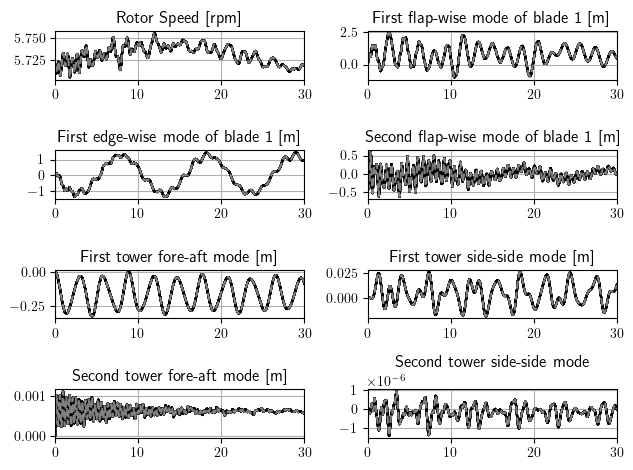

In [46]:
import matplotlib.pyplot as plt

xmax = 30 

plt.subplot(4, 2, 1)
plt.plot(time,qdt.transpose()[4]*60/2/np.pi, linestyle='-',color='black', label='ElastoDyn')
plt.plot(df['Time_[s]'], Omega*60/2/np.pi, linestyle='--', color='0.5', label='TorqTwin')
plt.xlim(0,xmax)
plt.title('Rotor Speed [rpm]')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(time,q.transpose()[5][:], linestyle='-',color='black')
plt.plot(df['Time_[s]'],df['Q_B1F1_[m]'], linestyle='--', color='0.5')
plt.grid(True)
plt.xlim(0,xmax)
plt.title('First flap-wise mode of blade 1 [m]')

plt.subplot(4, 2, 3)
plt.plot(time,q.transpose()[5+1][:], linestyle='-',color='black')
plt.plot(df['Time_[s]'],df['Q_B1E1_[m]'], linestyle='--',color='0.5')
plt.xlim(0,xmax)
plt.grid(True)
plt.title('First edge-wise mode of blade 1 [m]')


plt.subplot(4, 2, 4)
plt.plot(time,q.transpose()[6+1][:], linestyle='-',color='black')
plt.plot(df['Time_[s]'],df['Q_B1F2_[m]'], linestyle='--',color='0.5')
plt.xlim(0,xmax)
plt.grid(True)
plt.title('Second flap-wise mode of blade 1 [m]')


plt.subplot(4, 2, 5)
plt.plot(time,q.transpose()[0], linestyle='-',color='black')
plt.plot(df['Time_[s]'],df['Q_TFA1_[m]'], linestyle='--',color='0.5')
plt.xlim(0,xmax)
plt.grid(True)
plt.title('First tower fore-aft mode [m]')


plt.subplot(4, 2, 6)
plt.plot(time,q.transpose()[1], linestyle='-',color='black')
plt.plot(df['Time_[s]'],-df['Q_TSS1_[m]'], linestyle='--',color='0.5')  # the coordinate in elastodyn is different in y 
plt.xlim(0,xmax)
plt.title('First tower side-side mode [m]')


plt.subplot(4, 2, 7)
plt.plot(time,q.transpose()[2], linestyle='-',color='black')
plt.plot(df['Time_[s]'],df['Q_TFA2_[m]'], linestyle='--',color='0.5')
plt.xlim(0,xmax)
plt.grid(True)
plt.title('Second tower fore-aft mode [m]')


plt.subplot(4, 2, 8)
plt.plot(time,q.transpose()[3], linestyle='-',color='black')
plt.plot(df['Time_[s]'],-df['Q_TSS2_[m]'], linestyle='--',color='0.5')
plt.xlim(0,xmax)
plt.grid(True)
plt.title('Second tower side-side mode')

# Adjust layout for better spacing
plt.tight_layout()
#plt.rc('text', usetex=True)
#plt.legend(loc='upper right', fontsize='large', fancybox=True, framealpha=0.7, edgecolor='gray', facecolor='lightgray', ncol=2)

# Show the plot
plt.show()